In [285]:
from keras.datasets import fashion_mnist

(X_train, _), (X_test, _) = fashion_mnist.load_data()

In [286]:
X_train = np.concatenate([X_train, X_test])
X_train = X_train.astype(np.float32) / 255.

In [287]:
from keras.layers import Dense, Reshape, Flatten, LeakyReLU, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape =[100]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        64, (5, 5), (2, 2), padding ="same", activation ="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        1, (5, 5), (2, 2), padding ="same", activation ="tanh"),
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same", input_shape =[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation ='sigmoid')
])

In [288]:
discriminator.compile(loss ="binary_crossentropy", optimizer ="adam")
discriminator.trainable = False

gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss ="binary_crossentropy", optimizer ="adam")

In [289]:
discriminator.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)            

In [290]:
def create_batch(x_train):
    dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
    dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
    return dataset

In [291]:
def generate_and_save_images(model, epoch, img) -> None:
    predictions = model(img, training = False)

    fig = plt.figure(figsize =(10, 10))

    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap ='binary')
        plt.axis('off')

    plt.savefig('photos/image_epoch_{:04d}.png'.format(epoch))

In [292]:
import numpy as np
from tqdm import tqdm

def train_dcgan(gan, dataset, batch_size, num_features, predefined_noise, epochs):
    history = {'d_loss': [], 'g_loss': []}
    generator, discriminator = gan.layers
    
    for epoch in tqdm(range(epochs)):
        d_loss_list, g_loss_list = [], []
        
        print("Epoch {}/{}".format(epoch + 1, epochs))

        for X_batch in tqdm(dataset, total=len(dataset), desc='Processing batches'):
            noise = tf.random.normal(shape =[batch_size, num_features])
            generated_images = generator(noise)

            X_fake_and_real = np.concatenate([generated_images, X_batch])
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            discriminator.trainable = True
            
            d_loss = discriminator.train_on_batch(X_fake_and_real, y1)
            d_loss_list.append(d_loss)

            noise = tf.random.normal(shape =[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            
            discriminator.trainable = False
            
            g_loss = gan.train_on_batch(noise, y2)
            g_loss_list.append(g_loss)
            
        d_loss = np.mean(d_loss_list)
        g_loss = np.mean(g_loss_list)
        
        history['d_loss'].append(d_loss)
        history['g_loss'].append(g_loss)
        
        print(f'Discriminator loss: {d_loss:.4f}, Generator loss: {g_loss:.4f}')

        generate_and_save_images(generator, epoch, predefined_noise)
    return history

In [293]:
batch_size = 512
latent_size = 100

X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

dataset = create_batch(X_train_dcgan)
predefined_noise = tf.random.normal(shape =[batch_size, latent_size])

In [ ]:
history = train_dcgan(gan, dataset, batch_size, latent_size, predefined_noise, epochs=10)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch 1/10



Processing batches: 100%|█████████████████████| 136/136 [01:06<00:00,  2.04it/s]


Discriminator loss: 0.3803, Generator loss: 2.5450


 10%|████▍                                       | 1/10 [01:07<10:04, 67.21s/it]

Epoch 2/10



Processing batches:  79%|████████████████▌    | 107/136 [00:50<00:13,  2.16it/s]

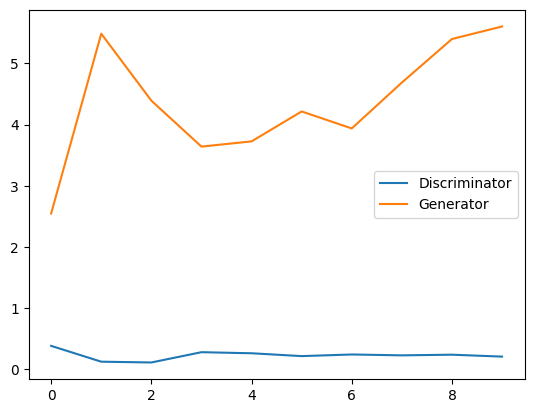

In [295]:
plt.plot(history['d_loss'], label='Discriminator')
plt.plot(history['g_loss'], label='Generator')
plt.legend()
plt.show()

1/1 [==============================] - 0s 98ms/step


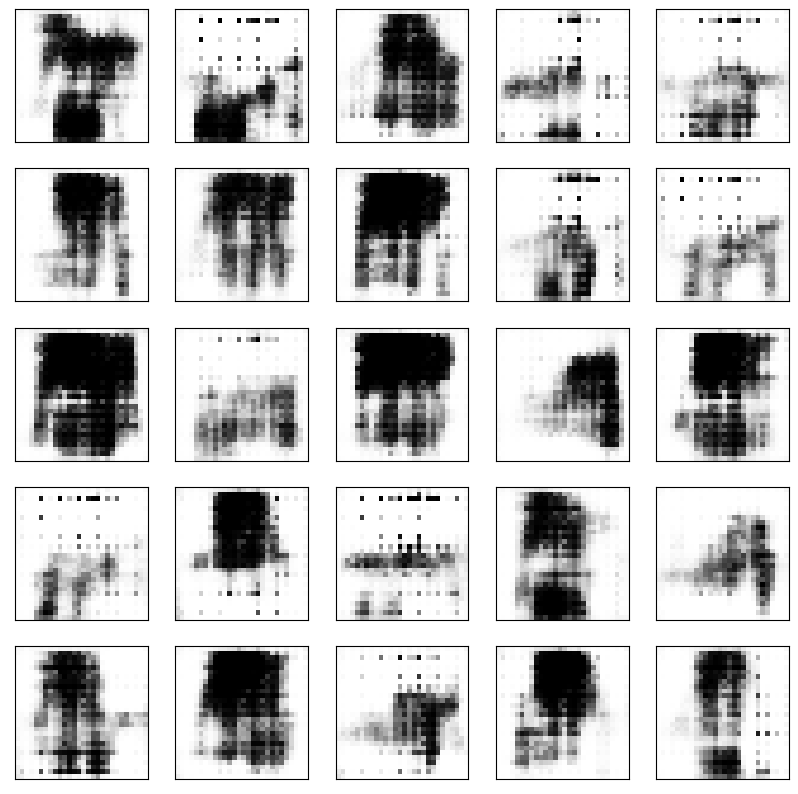

In [297]:
import matplotlib.pyplot as plt

# Generate some synthetic images
noise = np.random.randn(25, 100)
synthetic_images = generator.predict(noise)

# Plot the synthetic images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(synthetic_images[i], cmap=plt.cm.binary)
plt.show()

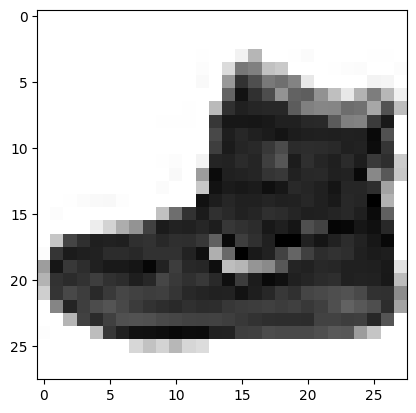

In [84]:
plt.imshow(X_train[0], cmap=plt.cm.binary)

# Task2

In [26]:
import os
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

RS = 47

# Download and extract the dataset
if not os.path.exists('deu-eng.zip'):
    !wget https://www.manythings.org/anki/deu-eng.zip
    !unzip deu-eng.zip

In [282]:
def load_data(path, num_samples=None):
    df = pd.read_csv(path, header=None, names=['english', 'german', 'other'], sep='\t')
    df = df[:num_samples]
    return df['english'].tolist(), df['german'].tolist()

def preprocess_data(english, german=None):
    english = [s.lower() for s in english]
    english = [re.sub(r'[^\w\s]', '', s) for s in english]
    
    if german is not None:
        german = [s.lower() for s in german]
        german = [re.sub(r'[^\w\s]', '', s) for s in german]
        return english, german
    return english

In [229]:
english, german = load_data('deu.txt', num_samples=50000)
english, german = preprocess_data(english, german)

In [237]:
max_length_english = max([len(i.split()) for i in english])
max_length_german = max([len(i.split()) for i in german])

In [238]:
max_length_english, max_length_german

(6, 15)

In [239]:
english_train, english_val, german_train, german_val = train_test_split(english, german, 
                                                                        test_size=0.2, shuffle=False, 
                                                                        random_state=RS)

In [240]:
latent_dim = 128
max_words_in_english = 10_000 # maximum number of words to consider in the English vocabulary
max_words_in_german = 10_000 # maximum number of words to consider in the German vocabulary

In [241]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenize the text and create vocabulary for both languages
english_tokenizer = Tokenizer(num_words=max_words_in_english)
english_tokenizer.fit_on_texts(english_train)
english_vocab_size = len(english_tokenizer.word_index) + 1

german_tokenizer = Tokenizer(num_words=max_words_in_german)
german_tokenizer.fit_on_texts(german_train)
german_vocab_size = len(german_tokenizer.word_index) + 1

english_train_padded = pad_sequences(english_tokenizer.texts_to_sequences(english_train), maxlen=max_length_english, padding='post')
german_train_padded = pad_sequences(german_tokenizer.texts_to_sequences(german_train), maxlen=max_length_german, padding='post')
english_test_padded = pad_sequences(english_tokenizer.texts_to_sequences(english_val), maxlen=max_length_english, padding='post')
german_test_padded = pad_sequences(german_tokenizer.texts_to_sequences(german_val), maxlen=max_length_german, padding='post')

In [243]:
from keras.layers import Embedding, LSTM, RepeatVector, Dense, Activation, TimeDistributed

model = keras.Sequential()

model.add(Embedding(english_vocab_size, latent_dim, input_length=max_length_english, mask_zero=True))
model.add(LSTM(128))
model.add(RepeatVector(max_length_german))
model.add(LSTM(128, return_sequences=True))

# add a dense layer for prediction
model.add(TimeDistributed(Dense(german_vocab_size)))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 6, 128)            690176    
                                                                 
 lstm_64 (LSTM)              (None, 128)               131584    
                                                                 
 repeat_vector_16 (RepeatVec  (None, 15, 128)          0         
 tor)                                                            
                                                                 
 lstm_65 (LSTM)              (None, 15, 128)           131584    
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 8661)         1117269   
 stributed)                                                      
                                                                 
 activation_15 (Activation)  (None, 15, 8661)        

In [244]:
history = model.fit(english_train_padded, german_train_padded, 
                    validation_data=(english_test_padded, german_test_padded), 
                    epochs=50, batch_size=256)

Epoch 1/50
157/157 [==============================] - 41s 226ms/step - loss: 3.1439 - accuracy: 0.7344 - val_loss: 2.2296 - val_accuracy: 0.7094
Epoch 2/50
157/157 [==============================] - 34s 218ms/step - loss: 1.8589 - accuracy: 0.7417 - val_loss: 1.9752 - val_accuracy: 0.7214
Epoch 3/50
157/157 [==============================] - 34s 217ms/step - loss: 1.7134 - accuracy: 0.7555 - val_loss: 1.8963 - val_accuracy: 0.7222
Epoch 4/50
157/157 [==============================] - 34s 219ms/step - loss: 1.6454 - accuracy: 0.7624 - val_loss: 1.8392 - val_accuracy: 0.7299
Epoch 5/50
157/157 [==============================] - 34s 219ms/step - loss: 1.5917 - accuracy: 0.7638 - val_loss: 1.8057 - val_accuracy: 0.7306
Epoch 6/50
157/157 [==============================] - 34s 219ms/step - loss: 1.5572 - accuracy: 0.7661 - val_loss: 1.7850 - val_accuracy: 0.7326
Epoch 7/50
157/157 [==============================] - 35s 221ms/step - loss: 1.5326 - accuracy: 0.7679 - val_loss: 1.7693 - val_ac

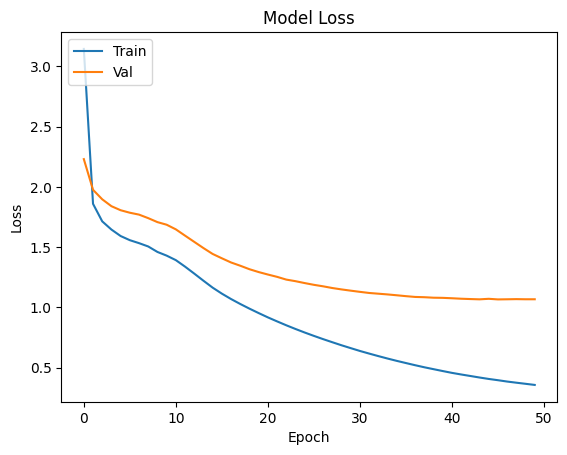

In [245]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [246]:
loss, acc = model.evaluate(english_test_padded, german_test_padded)
print(f'Acc: {acc:.4f}')

313/313 [==============================] - 7s 23ms/step - loss: 1.0671 - accuracy: 0.8177
Acc: 0.8177


In [284]:
english_sentences = ['I love cats', 'The weather is nice today', 'I am going to the store']
english_sentences = preprocess_data(english_sentences)
english_sentences_padded = pad_sequences(english_tokenizer.texts_to_sequences(english_sentences), maxlen=max_length_english, padding='post')
predictions = model.predict(english_sentences_padded)

for prediction in predictions:
    translation = []
    for word_prediction in prediction:
        index = np.argmax(word_prediction)
        if 0 < index < german_vocab_size:
            translation.append(german_tokenizer.index_word[index])
    print(' '.join(translation))

1/1 [==============================] - 0s 24ms/step
ich liebe katzen
das mutter ist ist gut
ich werde die


# Task3

In [331]:
from transformers import pipeline
from datasets import load_dataset

imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /home/receptor/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [323]:
sentiment_pipeline = pipeline('text-classification')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

In [328]:
texts = [
    "I had a great time at the movie. The acting was superb and the plot was engaging.",
    "I was disappointed by the movie. The acting was mediocre and the plot was confusing."
]

In [330]:
sentiment_pipeline(texts)

[{'label': 'POSITIVE', 'score': 0.9998676776885986},
 {'label': 'NEGATIVE', 'score': 0.9998102784156799}]

In [353]:
for i in range(5):
    text = imdb["test"][i]['text']
    label = imdb["test"][i]['label']

    print('###########################################################')
    print(f'{text}\n\nPredicted: {sentiment_pipeline(text)[0]["label"]}\n'
          f'Original: {"POSITIVE" if label else "NEGATIVE"}')
    print('###########################################################')

###########################################################
I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch.

In [355]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [356]:
input_text = "This movie was terrible"
input_ids = tokenizer.encode(input_text, return_tensors="tf")

logits = model(input_ids)[0]
probabilities = tf.nn.softmax(logits)
prediction = tf.argmax(probabilities, axis=-1)

In [362]:
print(prediction.numpy()[0])  # Outputs: 0 (indicating negative sentiment)

0
